In [155]:
import gym
from gym import spaces
import pickle
import pandas as pd
import numpy as np
import random
import tkinter as tk
from tkinter import *
import matplotlib.pyplot as plt
import torch
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction



In [156]:
with open('rl_data.pkl', 'rb') as handle:
    rl_data = pickle.load(handle)

In [157]:
rl_data[0]["observations"].shape

(104, 21)

In [243]:
class VesselEnvironment(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, rl_data, model_path="fc_transformer.pt"):
        self.rl_data = rl_data
        # load best 1% trips to calculate reward1
        self.hn_top = pd.read_csv("H2N_top1.csv")
        self.nh_top = pd.read_csv("N2H_top1.csv")
        # load scaler
        self.minmax_scaler = pickle.load(open('minmax_scaler.pkl', 'rb'))
        # get device
        if torch.cuda.is_available():
            self.device = torch.device('cuda:0')
        else:
            self.device = torch.device('cpu')
        # load fc forecasting model
        configuration = TimeSeriesTransformerConfig(prediction_length=1,
        context_length=18, input_size=4, num_time_features=1,
        num_dynamic_real_features = 15, num_static_real_features = 4,
        return_dict = True)
        model = TimeSeriesTransformerForPrediction(configuration).to(self.device)
        model.load_state_dict(torch.load(model_path,map_location=torch.device(self.device)))
        model.eval()
        self.model = model

        # initialize values
        self.trip_id = random.randint(0, len(rl_data))
        self.current_step = 25
        self.reward_cum = 0
        self.obs = np.zeros([1,21], dtype=np.float64)
        self.actions = np.zeros([1,3], dtype=np.float64)

    def _get_observation(self):
        return torch.from_numpy(self.obs[-1])

    def reset(self, seed=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)
        self.trip_id = random.randint(0, len(rl_data))
        self.current_step = 25
        self.obs = self.rl_data[self.trip_id]["observations"][0:25]
        self.actions = self.rl_data[self.trip_id]["actions"][0:25]
        # get direction and other static features
        self.direction = self.rl_data[self.trip_id]["observations"][0, 14]
        self.statics = self.rl_data[self.trip_id]["observations"][0, 13:17]
        if self.direction==1:
            self.top1 = self.hn_top
            self.goal_long, self.goal_lat =  np.float64(-123.2715), np.float64(49.3771)
            self.start_long, self.start_lat =  np.float64(-123.9554), np.float64(49.1936)
        else:
            self.top1 = self.nh_top
            self.goal_long, self.goal_lat =np.float64(-123.9554), np.float64(49.1936)
            self.start_long, self.start_lat =  np.float64(-123.9554), np.float64(49.1936)
        # calculate the cumulative reward
        self.reward_cum = np.sum(self.rl_data[self.trip_id]["rewards"][:25, :])/3

        return self._get_observation()
    
    def _take_action(self, action):
        # time_feature = ["Time2"]
        # dynamic_real_feature = [ "SPEED", "HEADING",
        #     "turn", 'disp', "distance_s" ,"distance_d", "DEPTH", "resist_ratio",
        #     'current', 'rain', 'snowfall', "pressure", 'wind_force', 'wind_direc',
        #     "MODE",]
        # static_categorical_feature = ["is_weekday", 'direction', 'adversarial', "season"]
        # y_cols = ['FC', "LATITUDE", 'LONGITUDE', 'SOG']
        # obs_cols = ["Time2",
        #    "turn", 'disp', "distance_s" ,"distance_d", "DEPTH", "resist_ratio",
        #    'current', 'rain', 'snowfall', "pressure", 'wind_force', 'wind_direc', 
        #    "is_weekday", 'direction', 'adversarial', "season",
        #    'FC', "LATITUDE", 'LONGITUDE', 'SOG', ]
        # action_cols =  ["HEADING", "SPEED", "MODE"]
        last_obs = self.obs[-1]
        last_action = self.actions[-1]
        if self.current_step < self.rl_data[self.trip_id]["observations"].shape[0]:
            future_obs = self.rl_data[self.trip_id]["observations"][self.current_step]
        else: 
            future_obs = self.rl_data[self.trip_id]["observations"][-1]
        future_time_features = np.zeros([1,16])
        future_time_features[0,0] = last_obs[0] + 0.006211 # time
        future_time_features[0,1] = action[0] # heading
        future_time_features[0,2] = action[1] # speed
        future_time_features[0,3] = action[0] - last_action[0] # turn
        lat_last, long_last = self._inv_transform_location(last_obs[-3],last_obs[-2])
        lat_last2, long_last2 = self._inv_transform_location(self.obs[-2,-3],self.obs[-2,-2])
        disp = (((lat_last2-lat_last)**2 + (long_last2-long_last))**2)**1/2
        distance_s = (((lat_last2-self.start_lat)**2 + (long_last2-self.start_long))**2)**1/2
        distance_d = (((lat_last2-self.goal_lat)**2 + (long_last2-self.goal_long))**2)**1/2
        disp_vals= self._transform_value([disp, distance_s, distance_d], [4, 5, 6])
        future_time_features[0,4] = disp_vals[0]         # disp

        future_time_features[0,5:7] = np.array([disp_vals[1], disp_vals[2]])  # distance_s, distance_d
        # "distance_s" ,"distance_d" = last long lat - last last long_lat - start/ end
        future_time_features[0, 7:15] = future_obs[5:13]
        future_time_features[0, 15] = action[2] # mode

        past_values = self.obs[-25:, 17:]

        past_time_features = np.zeros([25, 16])
        past_time_features[:, 0] = self.obs[-25:, 0]
        past_time_features[:, [1,2]] = self.actions[-25:, [0,1]] # heading and speed
        past_time_features[:, -1] = self.actions[-25:, -1] # heading
        past_time_features[:, 3:15] = self.obs[-25:, 1:13]

        new_observe = np.zeros([1,21])
        new_observe[0, 0] = future_time_features[0, 0]
        new_observe[0, 1:13] = future_time_features[0, 3:15]
        new_observe[0, 13:17] = self.statics

        fc, lat_minmax, long_minmax, sog = self._predict(past_values, past_time_features, future_time_features)
        new_observe[0, 17] = fc
        new_observe[0, 18] = lat_minmax
        new_observe[0, 19] = long_minmax
        new_observe[0, 20] = sog
        
        # modify last 25 observations and actions
        self.obs = np.append(self.obs, new_observe, axis=0)
        self.actions = np.append(self.actions, np.expand_dims(action, 0), axis=0)
        lat, long = self._inv_transform_location(lat_minmax, long_minmax)

        return fc, lat, long

    def _predict(self, past_values, past_time_features, future_time_features):
        self.model.eval()
        self.model.to(self.device)
        future_time_features = torch.from_numpy(np.expand_dims(future_time_features, 0)).float().to(self.device)
        past_values = torch.from_numpy(np.expand_dims(past_values, 0)).float().to(self.device)
        past_time_features = torch.from_numpy(np.expand_dims(past_time_features, 0)).float().to(self.device)
        # print(future_time_features.shape, past_time_features.shape)
        static_real_features = torch.from_numpy(np.expand_dims(self.statics, 0)).float().to(self.device)
        past_observed_mask = torch.ones(past_values.shape).to(self.device)
        # print("past_time_features", past_time_features)
        # print("future_time_features", future_time_features)
        # print("static_real_features", static_real_features)

        # print(past_time_features.dtype)
        with torch.no_grad():
            outputs = self.model.generate(past_values=past_values, past_time_features=past_time_features,
                    static_real_features=static_real_features, past_observed_mask=past_observed_mask, 
                    future_time_features=future_time_features)
        outputs = outputs.sequences.mean(dim=1).detach().cpu().numpy()
        fc, lat_minmax, long_minmax, speed= outputs[0,0,0], outputs[:,0,1], outputs[:,0,2], outputs[:,0,3]
        return fc, lat_minmax, long_minmax, speed

    def _get_reward(self, long, lat, fc):
        reward1 = ((long-self.top1["LONGITUDE"])**2 + (lat-self.top1["LATITUDE"])**2 )**0.5
        reward2 = -fc
        reward3 = ((self.goal_long-long)**2 + (self.goal_lat-lat)**2 )**0.5
        return (reward1 + reward2 + reward3) / 3

    def step(self, action):
        obs= self._get_observation()
        self.current_step += 1

        # put inverse transform in render
        fc, lat, long= self._take_action(action)

        done = (abs(long-self.goal_long)<5e-5) & (abs(lat-self.goal_lat)<5e-5)
        
        reward = self._get_reward(long, lat, fc)
        self.reward_cum = self.reward_cum + reward

        if done:
            reward = reward+1/3
        return obs, self.reward_cum, done, {}


    def _inv_transform_location(self, lat, long):
        array = np.zeros([1, 18],dtype=np.float64)
        array[0, 13] = lat
        array[0, 14] = long
        array = self.minmax_scaler.inverse_transform(array)[0,[13, 14]]
        lat, long = array[0], array[1]
        return lat, long

    def _transform_value(self, vals, indexes):
        array = np.zeros([1, 18],dtype=np.float64)
        for i in range(len(indexes)):
            array[0, indexes[i]] = vals[i]
        transformed_val = self.minmax_scaler.transform(array)[0, [indexes]]
        return transformed_val[0]


    def render(self, mode="human"):
        lat, long = self.obs[:, -3].copy(), self.obs[:, -2].copy()
        for i in range(len(lat)):
            lat[i], long[i] = self._inv_transform_location(lat[i],long[i])
        # print( rl_data[self.trip_id]["actions"])
        # SOG = rl_data[self.trip_id]["actions"][:self.current_step, 1]

        # # print(long_lat)
        # # 调用Tk()创建主窗口
        # root_window =tk.Tk()
        # # 给主窗口起一个名字，也就是窗口的名字
        # root_window.title('gym_rendering')
        # root_window.geometry('450x450')
        # root_window["background"] = "#C9C9C9"
        # # 添加文本内,设置字体的前景色和背景色，和字体类型、大小
        # text=tk.Label(root_window,text="trip {} vessel route plot".format(self.trip_id),bg="yellow",fg="red",font=('Times', 20, 'bold italic'))
        # text.pack()

        # generate the figure and plot object which will be linked to the root element
        fig, ax = plt.subplots()
        fig.set_size_inches(3.5, 3.5)
        # ax.scatter(long_lat[:,1],long_lat[:,0],c=stw, s=1)
        ax.scatter(long,lat, s=1)
        ax.set_xlim(xmin = -124.0, xmax= -123.2)
        ax.set_ylim(ymin=49.15, ymax=49.45)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7,rotation=90)
        # ax.axis("off")
        plt.subplots_adjust(top=0.925,     # Further fix clipping of text in the figure
                            bottom=0.16,
                            left=0.11,
                            right=0.90,
                            hspace=0.2,
                            wspace=0.2)
        # canvas = FigureCanvasTkAgg(fig,master=root_window)
        # canvas.draw()
        # canvas.get_tk_widget().place(relx=0.15, rely=0.15)

        # root_window.mainloop()

In [244]:
env = VesselEnvironment(rl_data)
a = env.reset()
step = env.step(np.array([0.85551542, 0.16972901, 1.        ]))

/Users/yim/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/yim/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


/Users/yim/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/Users/yim/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/Users/yim/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/Users/yim/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/Users/yim/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxSc

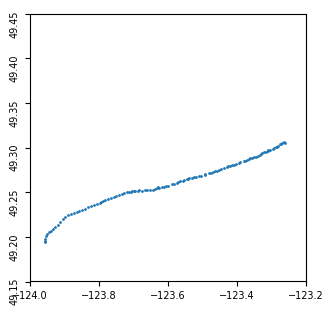

In [253]:
for i in range(10):
    step = env.step(np.array([0.85551542, 0.16972901, 1.        ]))
env.render()

In [297]:
# import tkinter as tk
# from tkinter import *

# # 调用Tk()创建主窗口
# root_window =tk.Tk()
# # 给主窗口起一个名字，也就是窗口的名字
# root_window.title('gym_rendering')
# root_window.geometry('450x450')
# root_window["background"] = "#C9C9C9"
# # 添加文本内,设置字体的前景色和背景色，和字体类型、大小
# text=tk.Label(root_window,text="info here",bg="yellow",fg="red",font=('Times', 20, 'bold italic'))
# text.pack()
# # 添加按钮，以及按钮的文本，并通过command 参数设置关闭窗口的功能
# # button=tk.Button(root_window,text="close",command=root_window.destroy)
# # 将按钮放置在主窗口内
# # button.pack(side="bottom")
# #开启主循环，让窗口处于显示状态
# cv=Canvas(root_window,bg="white",width =300, height = 250)
# # 将控件放置在主窗口中
# cv.pack()
# # 设置坐标点,此处可以元组的形式来设置坐标点
# point=[(10,20),(20,30),(30,40),(40,100),(80,120),(150,90)]
# # 创建画布，添加线条
# # fill 参数指定填充的颜色，如果为空字符串，则表示透明
# # dash 参数表示用来绘制虚线轮廓，元组参数，分别代表虚线中线段的长度和线段之间的间隔
# # arrow 设线段的箭头样式，默认不带箭头，参数值 first 表示添加箭头带线段开始位置，last表示到末尾占位置，both表示两端均添加
# # smooth 布尔值参数，表示是否以曲线的样式划线，默认为 False
# # width 控制线宽
# line1=cv.create_line(point,fill="purple",dash=(1,1),arrow=LAST,width=5)
# print('线段line1的画布id号:',line1)
# # line2=cv.create_line(point,fill="red",arrow=BOTH,smooth=TRUE,width=5)
# # print('线段line2的画布id号:',line2)
# # 移动其中一条线段，只需要更改其坐标就可以,使用 coords()方法移动曲线
# # 显示窗口

# root_window.mainloop()

In [ ]:
# obs_cols = ["Time2",
        #    "turn", 'disp', "distance_s" ,"distance_d", "DEPTH", "resist_ratio",
        #    'current', 'rain', 'snowfall', "pressure", 'wind_force', 'wind_direc', 
        #    "is_weekday", 'direction', 'adversarial', "season",
        #    'FC', "LATITUDE", 'LONGITUDE', 'SOG', ]

In [ ]:
time_feature = ["Time2"]
dynamic_real_feature = [ "SPEED", "HEADING", 
       "turn", 'disp', "distance_s" ,"distance_d",
       'current', 'rain', 'snowfall', "pressure", 'wind_force', 'wind_direc', 
       "MODE",]
static_real_feature = ["is_weekday", 'direction', 'adversarial', "season",]
y_cols = ['FC', "LATITUDE", 'LONGITUDE', 'SOG', "DEPTH", "resist_ratio"]

context_length = 18
prediction_horizon = 1

# MODEL
configuration = TimeSeriesTransformerConfig(prediction_length=prediction_horizon,
        context_length=context_length, input_size=len(y_cols), num_time_features=len(time_feature),
        num_dynamic_real_features = len(dynamic_real_feature), num_static_real_features = len(static_real_feature),
        return_dict = False, use_cache=False)
model = TimeSeriesTransformerForPrediction(configuration)
model.load_state_dict(torch.load("transformer7_1_checkpoint.pt"))
model.eval()
